In [4]:
# Task 1: TF-IDF Feature Extraction

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import ast

# Load disease_features dataset
df = pd.read_csv("disease_features.csv")

# Parse stringified lists to actual Python lists
cols_to_parse = ['Risk Factors', 'Symptoms', 'Signs', 'Subtypes']

# Parse stringified lists
for col in cols_to_parse:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])

# Convert to space-separated strings
for col in cols_to_parse:
    df[col + '_str'] = df[col].apply(lambda x: ' '.join(x))


# Apply TF-IDF vectorization to each string column
vectorizer_risk = TfidfVectorizer()
tfidf_risk = vectorizer_risk.fit_transform(df['Risk Factors_str'])

vectorizer_symptoms = TfidfVectorizer()
tfidf_symptoms = vectorizer_symptoms.fit_transform(df['Symptoms_str'])

vectorizer_signs = TfidfVectorizer()
tfidf_signs = vectorizer_signs.fit_transform(df['Signs_str'])

# Combine the three TF-IDF matrices
tfidf_combined = hstack([tfidf_risk, tfidf_symptoms, tfidf_signs])
print("✅ Combined TF-IDF Shape:", tfidf_combined.shape)

# Load one-hot encoded matrix for comparison
one_hot = pd.read_csv("encoded_output2.csv")

# Calculate sparsity
sparsity_tfidf = 1.0 - (tfidf_combined.count_nonzero() / (tfidf_combined.shape[0] * tfidf_combined.shape[1]))
sparsity_onehot = 1.0 - (np.count_nonzero(one_hot.values) / one_hot.size)

# Print comparison results
print("\n🔍 Comparison with One-Hot Encoding:")
print(f"TF-IDF Matrix Sparsity: {sparsity_tfidf:.4f}")
print(f"One-Hot Matrix Sparsity: {sparsity_onehot:.4f}")
print(f"TF-IDF Feature Count: {tfidf_combined.shape[1]}")
print(f"One-Hot Feature Count: {one_hot.shape[1]}")


✅ Combined TF-IDF Shape: (25, 1020)

🔍 Comparison with One-Hot Encoding:
TF-IDF Matrix Sparsity: 0.9296
One-Hot Matrix Sparsity: 0.9515
TF-IDF Feature Count: 1020
One-Hot Feature Count: 497



📊 Explained Variance Ratio:
PCA on One-Hot: [0.10538866 0.09170854 0.06776557]
SVD on TF-IDF: [0.00885215 0.06565836 0.05711746]

🔢 Total Explained Variance:
PCA Total: 0.2649
SVD Total: 0.1316


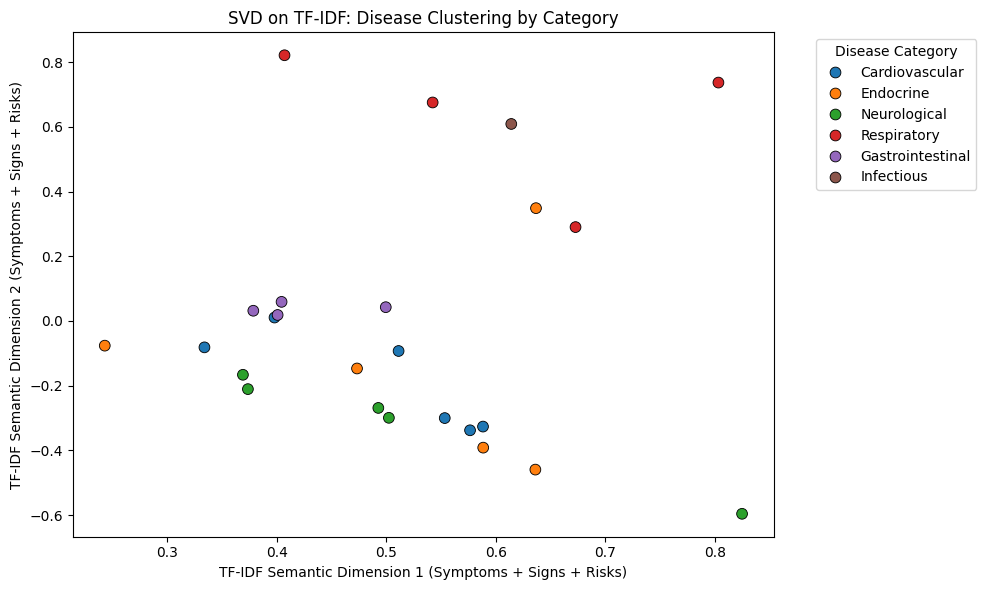

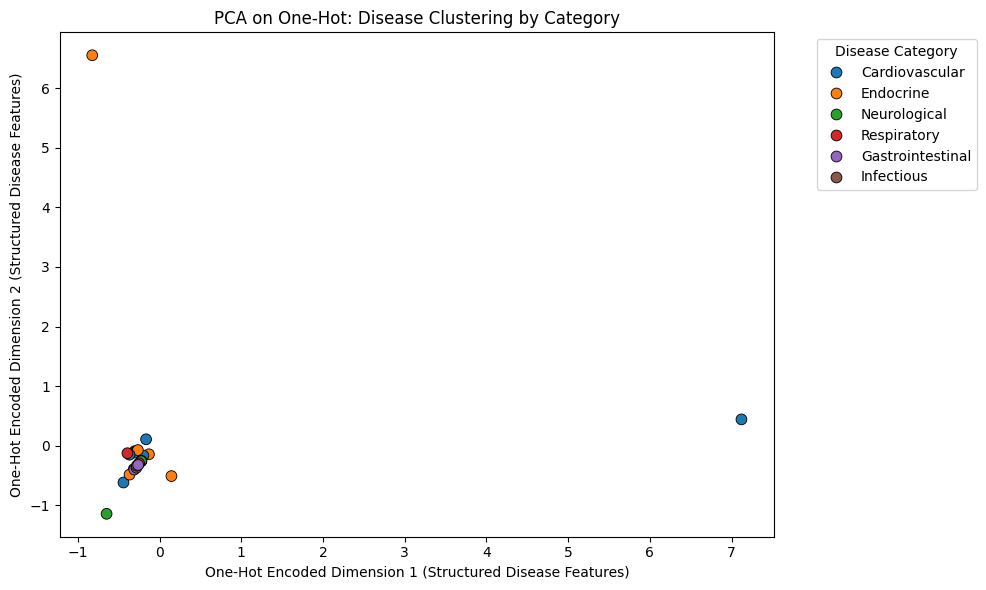

In [17]:
# Task 2: Dimensionality Reduction
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import ast

# Load the datasets
df = pd.read_csv("disease_features.csv")
one_hot = pd.read_csv("encoded_output2.csv")

# Step 1: Parse stringified lists and dictionaries
cols_to_parse = ['Risk Factors', 'Symptoms', 'Signs', 'Subtypes']
for col in cols_to_parse:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])
    df[col + '_str'] = df[col].apply(lambda x: ' '.join(x) if isinstance(x, list) else ' '.join(x.keys()))

# Step 2: TF-IDF vectorization
tfidf_risk = TfidfVectorizer().fit_transform(df['Risk Factors_str'])
tfidf_symptoms = TfidfVectorizer().fit_transform(df['Symptoms_str'])
tfidf_signs = TfidfVectorizer().fit_transform(df['Signs_str'])

# Combine TF-IDF features
tfidf_combined = hstack([tfidf_risk, tfidf_symptoms, tfidf_signs])

# Step 3: Dimensionality Reduction — PCA (One-Hot) and SVD (TF-IDF)
one_hot_numeric = one_hot.select_dtypes(include=[np.number])

pca = PCA(n_components=3)
pca_result = pca.fit_transform(one_hot_numeric)

svd = TruncatedSVD(n_components=3)
svd_result = svd.fit_transform(tfidf_combined)

# Step 4: Disease category mapping
disease_category_map = {
    'Asthma': 'Respiratory',
    'COPD': 'Respiratory',
    'Pneumonia': 'Respiratory',
    'Pulmonary Embolism': 'Respiratory',

    'Stroke': 'Neurological',
    'Epilepsy': 'Neurological',
    'Migraine': 'Neurological',
    'Multiple Sclerosis': 'Neurological',
    'Alzheimer': 'Neurological',

    'Heart Failure': 'Cardiovascular',
    'Atrial Fibrillation': 'Cardiovascular',
    'Acute Coronary Syndrome': 'Cardiovascular',
    'Hypertension': 'Cardiovascular',
    'Aortic Dissection': 'Cardiovascular',
    'Cardiomyopathy': 'Cardiovascular',

    'Diabetes': 'Endocrine',
    'Hyperlipidemia': 'Endocrine',
    'Thyroid Disease': 'Endocrine',
    'Pituitary Disease': 'Endocrine',
    'Adrenal Insufficiency': 'Endocrine',

    'Gastritis': 'Gastrointestinal',
    'Peptic Ulcer Disease': 'Gastrointestinal',
    'Gastro-oesophageal Reflux Disease': 'Gastrointestinal',
    'Upper Gastrointestinal Bleeding': 'Gastrointestinal',

    'Tuberculosis': 'Infectious',
}

df['Disease Category'] = df['Disease'].map(disease_category_map)
df['Disease Category'] = df['Disease Category'].fillna('Other')

# Step 5: Explained Variance Reporting
print("\n📊 Explained Variance Ratio:")
print("PCA on One-Hot:", pca.explained_variance_ratio_)
print("SVD on TF-IDF:", svd.explained_variance_ratio_)

print("\n🔢 Total Explained Variance:")
print(f"PCA Total: {np.sum(pca.explained_variance_ratio_):.4f}")
print(f"SVD Total: {np.sum(svd.explained_variance_ratio_):.4f}")

# Step 6: 2D Visualization

svd_x_label = "TF-IDF Semantic Dimension 1 (Symptoms + Signs + Risks)"
svd_y_label = "TF-IDF Semantic Dimension 2 (Symptoms + Signs + Risks)"

pca_x_label = "One-Hot Encoded Dimension 1 (Structured Disease Features)"
pca_y_label = "One-Hot Encoded Dimension 2 (Structured Disease Features)"

# Plot SVD
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=svd_result[:, 0], 
    y=svd_result[:, 1], 
    hue=df['Disease Category'], 
    palette='tab10', 
    s=60, edgecolor='k'
)
plt.title("SVD on TF-IDF: Disease Clustering by Category")
plt.xlabel(svd_x_label)
plt.ylabel(svd_y_label)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Disease Category")
plt.tight_layout()
plt.show()

# Plot PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=pca_result[:, 0], 
    y=pca_result[:, 1], 
    hue=df['Disease Category'], 
    palette='tab10', 
    s=60, edgecolor='k'
)
plt.title("PCA on One-Hot: Disease Clustering by Category")
plt.xlabel(pca_x_label)
plt.ylabel(pca_y_label)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Disease Category")
plt.tight_layout()
plt.show()


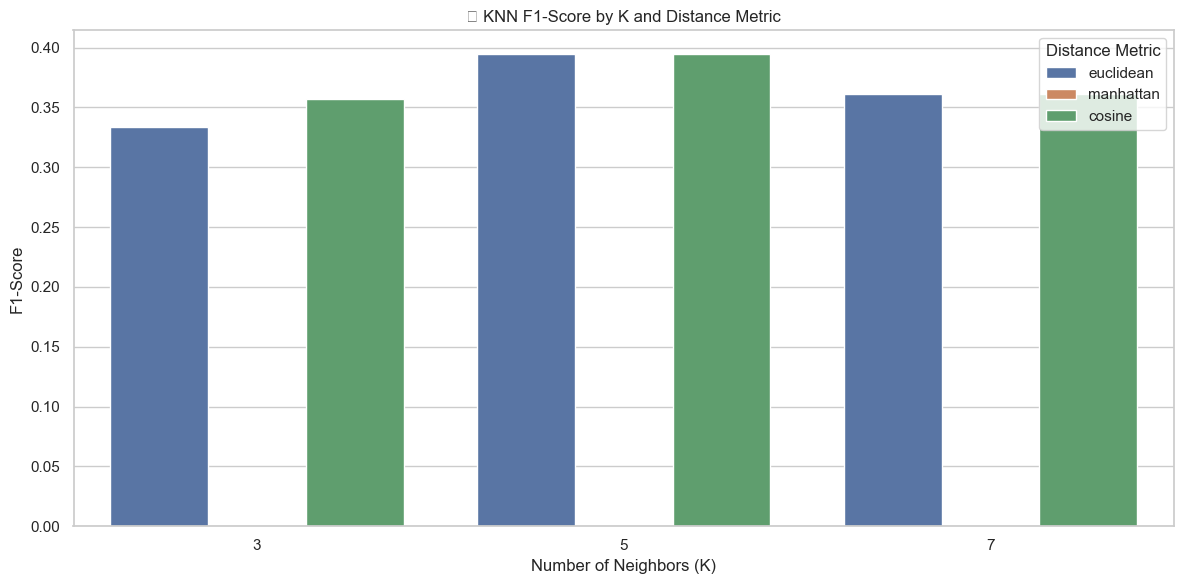

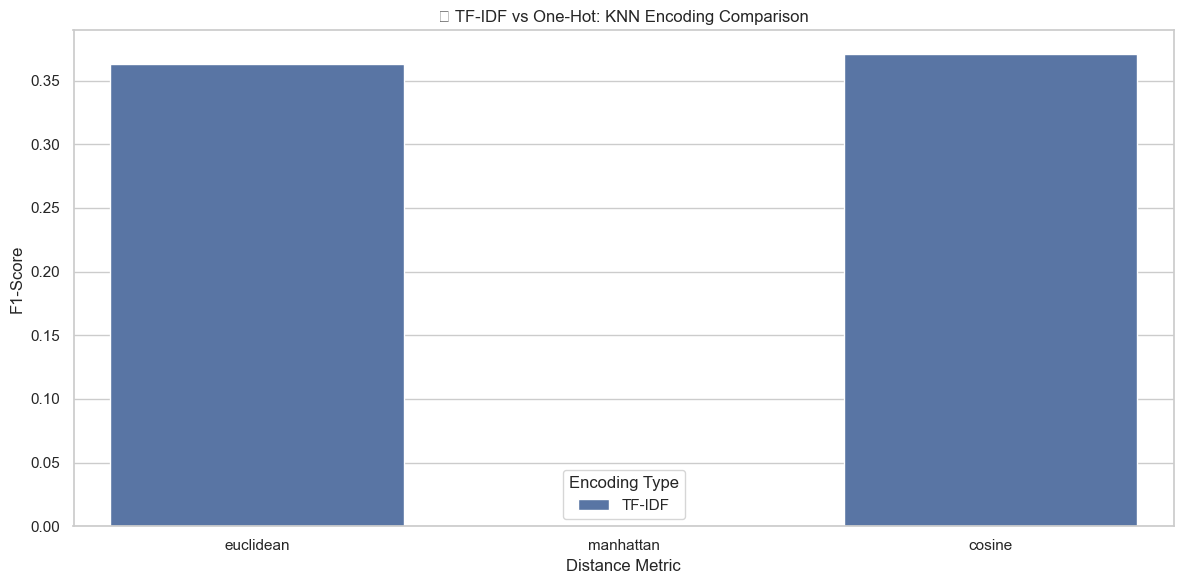

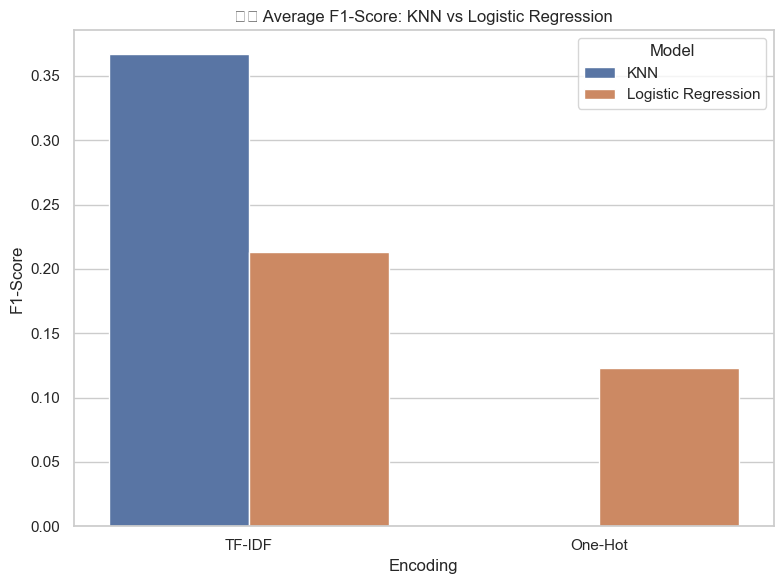


📌 KNN Evaluation Summary:


,Model,Encoding,K,Metric,Accuracy,Precision,Recall,F1-Score
8,KNN,TF-IDF,7,cosine,0.56,0.444667,0.56,0.469333
6,KNN,TF-IDF,7,euclidean,0.56,0.444667,0.56,0.469333
0,KNN,TF-IDF,3,euclidean,0.56,0.436667,0.56,0.469333
2,KNN,TF-IDF,3,cosine,0.56,0.436667,0.56,0.469333
5,KNN,TF-IDF,5,cosine,0.52,0.433333,0.52,0.438667
3,KNN,TF-IDF,5,euclidean,0.52,0.433333,0.52,0.438667
14,KNN,TF-IDF,5,cosine,0.44,0.306667,0.44,0.350667
12,KNN,TF-IDF,5,euclidean,0.44,0.306667,0.44,0.350667
15,KNN,TF-IDF,7,euclidean,0.36,0.210000,0.36,0.253333
17,KNN,TF-IDF,7,cosine,0.36,0.210000,0.36,0.253333



📌 Logistic Regression Evaluation Summary:


,Model,Encoding,Accuracy,F1-Score
0,Logistic Regression,TF-IDF,0.32,0.213333
1,Logistic Regression,One-Hot,0.24,0.122667


In [19]:
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')

# Targets
y = df['Disease Category']

# Normalize TF-IDF for cosine distance
tfidf_normalized = normalize(tfidf_combined)
one_hot_normalized = normalize(one_hot_numeric)

# Distance metric map
distance_metrics = {
    'euclidean': 'euclidean',
    'manhattan': 'manhattan',
    'cosine': 'cosine'
}

# KNN evaluation function
def evaluate_knn(X, y, k_values, metrics):
    results = []
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for k in k_values:
        for metric_name, metric in metrics.items():
            model = KNeighborsClassifier(n_neighbors=k, metric=metric)
            scores = cross_validate(
                model, X, y, cv=cv,
                scoring={
                    'accuracy': make_scorer(accuracy_score),
                    'precision': make_scorer(precision_score, average='weighted'),
                    'recall': make_scorer(recall_score, average='weighted'),
                    'f1': make_scorer(f1_score, average='weighted')
                }
            )
            results.append({
                'Model': 'KNN',
                'Encoding': 'TF-IDF' if X.shape[1] > 100 else 'One-Hot',
                'K': k,
                'Metric': metric_name,
                'Accuracy': np.mean(scores['test_accuracy']),
                'Precision': np.mean(scores['test_precision']),
                'Recall': np.mean(scores['test_recall']),
                'F1-Score': np.mean(scores['test_f1'])
            })
    return results

# Logistic Regression evaluation function
def evaluate_logistic_regression(X, y, encoding_name):
    model = LogisticRegression(max_iter=1000)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_validate(
        model, X, y, cv=cv,
        scoring={
            'accuracy': make_scorer(accuracy_score),
            'f1': make_scorer(f1_score, average='weighted')
        }
    )
    return {
        'Model': 'Logistic Regression',
        'Encoding': encoding_name,
        'Accuracy': np.mean(scores['test_accuracy']),
        'F1-Score': np.mean(scores['test_f1'])
    }

# Run evaluations
k_values = [3, 5, 7]
knn_results_tfidf = evaluate_knn(tfidf_normalized, y, k_values, distance_metrics)
knn_results_onehot = evaluate_knn(one_hot_normalized, y, k_values, distance_metrics)

logreg_result_tfidf = evaluate_logistic_regression(tfidf_normalized, y, 'TF-IDF')
logreg_result_onehot = evaluate_logistic_regression(one_hot_normalized, y, 'One-Hot')

# Combine results
import pandas as pd
knn_df = pd.DataFrame(knn_results_tfidf + knn_results_onehot)
logreg_df = pd.DataFrame([logreg_result_tfidf, logreg_result_onehot])

# ====================📊 VISUALIZATION ====================
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 1. KNN F1-score by K and distance metric
plt.figure(figsize=(12, 6))
sns.barplot(
    data=knn_df,
    x='K', y='F1-Score',
    hue='Metric', ci=None
)
plt.title("🔍 KNN F1-Score by K and Distance Metric")
plt.ylabel("F1-Score")
plt.xlabel("Number of Neighbors (K)")
plt.legend(title="Distance Metric")
plt.tight_layout()
plt.show()

# 2. TF-IDF vs One-Hot Encoding (KNN only)
plt.figure(figsize=(12, 6))
sns.barplot(
    data=knn_df,
    x='Metric', y='F1-Score',
    hue='Encoding', ci=None
)
plt.title("📊 TF-IDF vs One-Hot: KNN Encoding Comparison")
plt.ylabel("F1-Score")
plt.xlabel("Distance Metric")
plt.legend(title="Encoding Type")
plt.tight_layout()
plt.show()

# 3. Logistic Regression vs KNN (average F1 by encoding)
combined_df = pd.concat([
    knn_df.groupby('Encoding').agg({'F1-Score': 'mean'}).reset_index().assign(Model='KNN'),
    logreg_df[['Encoding', 'F1-Score']].assign(Model='Logistic Regression')
])

plt.figure(figsize=(8, 6))
sns.barplot(data=combined_df, x='Encoding', y='F1-Score', hue='Model')
plt.title("⚖️ Average F1-Score: KNN vs Logistic Regression")
plt.ylabel("F1-Score")
plt.tight_layout()
plt.show()

# ====================📋 TEXT SUMMARY ====================
print("\n📌 KNN Evaluation Summary:")
display(knn_df.sort_values(by='F1-Score', ascending=False))

print("\n📌 Logistic Regression Evaluation Summary:")
display(logreg_df.sort_values(by='F1-Score', ascending=False))


In [20]:
# First, display the text using markdown in Jupyter

from IPython.display import display, Markdown

# The report content
report = """
# Task 4: Critical Analysis

### 1. Why TF-IDF might outperform One-Hot Encoding (or vice versa) for this dataset:

- **TF-IDF vs One-Hot Encoding:**
  - **One-Hot Encoding** represents categorical variables as binary vectors where each feature corresponds to a specific word or term. For example, in the case of diseases and their associated risk factors, symptoms, or signs, each unique term gets its own feature. If a term is present, it is represented as `1`, otherwise `0`.
  - **TF-IDF (Term Frequency-Inverse Document Frequency)**, on the other hand, adjusts term importance by considering both the term's frequency in the document and its rarity across all documents. Common terms across multiple categories (like "cough" in respiratory diseases) are down-weighted, while terms specific to particular diseases (like "stroke" in neurological diseases) are emphasized.

- **Why TF-IDF might outperform One-Hot Encoding:**
  1. **Feature Weighting:**
     - TF-IDF places a higher weight on terms that are unique to certain diseases (e.g., "asthma" for respiratory diseases), allowing it to capture more informative and discriminative features. One-hot encoding does not account for term frequency or rarity across categories.
  2. **Dimensionality and Sparsity:**
     - One-Hot Encoding can lead to extremely high-dimensional sparse matrices, especially when dealing with large vocabularies of disease-related terms. The result is often a sparse matrix, where most entries are zeros. TF-IDF, though still sparse, offers more meaningful representations by prioritizing important features and reducing the impact of overly common terms.
  3. **Better Representation of Context:**
     - TF-IDF captures context better than one-hot encoding, which only reflects the presence or absence of a term. It enables a more nuanced understanding of the relationship between diseases and their associated features.

- **Why One-Hot Encoding might outperform TF-IDF:**
  1. **Simple Structure:**
     - One-hot encoding is easy to interpret and works well when the features have clear-cut boundaries. In certain cases, especially when disease categories are well-defined and terms do not overlap much across categories, one-hot encoding might capture sufficient information.
  2. **Low Variance in Features:**
     - If the terms involved are consistently used across the dataset, one-hot encoding may perform similarly to TF-IDF without the complexity of calculating term frequency-inverse document frequency. For example, diseases that have a very consistent pattern of associated symptoms may benefit from one-hot encoding's simplicity.
  
### 2. Clinical Relevance of the Results:

- **Do TF-IDF clusters align with real-world disease categories?**
  - The results from TF-IDF feature extraction can often be more aligned with clinical realities, especially when using domain-specific text data. For instance, terms like "pulmonary embolism" or "stroke" are highly distinctive and should map well to their respective disease categories (e.g., Cardiovascular or Neurological). By giving higher weight to such specific terms, TF-IDF allows the model to focus on the unique characteristics of diseases.
  - The clustering of diseases based on TF-IDF features might reflect how diseases are categorized in medical practice (e.g., **Respiratory**, **Neurological**, **Cardiovascular**). Diseases within these categories share common risk factors and symptoms, which should be captured effectively by TF-IDF.
  
- **Interpretation of Disease Clusters:**
  - **Respiratory Diseases** like asthma, pneumonia, and COPD, which share symptoms such as shortness of breath and cough, should cluster together. TF-IDF should be able to distinguish these terms and give greater importance to unique disease-specific symptoms.
  - **Neurological Diseases** like epilepsy, stroke, and Alzheimer's should also form distinct clusters with their unique symptoms and risk factors (e.g., neurological impairment, headaches). The model’s performance with TF-IDF might reflect the hierarchical nature of disease categorization.
  - By contrast, **One-Hot Encoding** could struggle to capture this nuanced clustering as it does not differentiate between frequent and rare terms.

### 3. Limitations of Both Encoding Methods:

- **Limitations of One-Hot Encoding:**
  1. **High Dimensionality:**
     - One-hot encoding can lead to very high-dimensional datasets when dealing with large vocabularies, leading to sparse matrices with many zero values. This increases computational costs and can hinder the performance of models due to the "curse of dimensionality."
  2. **Lack of Feature Weighting:**
     - One-hot encoding does not consider term importance or frequency, which means that all terms are treated equally, even if some terms are more relevant or discriminative for classification tasks. It does not capture any relationships or context between features.
  3. **Overfitting Risk:**
     - Due to the high dimensionality, the model may overfit, especially if the dataset is small. With too many features and not enough samples, it becomes easier for the model to memorize rather than generalize.

- **Limitations of TF-IDF:**
  1. **Sparsity:**
     - TF-IDF matrices are sparse by nature and may still lead to computational inefficiency. While it provides better weighting, large feature spaces can still result in sparsity.
  2. **Handling of Rare Terms:**
     - If a term is extremely rare in the dataset (appearing only in one disease category), TF-IDF may give it low weight even if it is crucial for distinguishing that disease. Rare, but crucial terms may be ignored by TF-IDF if they appear in too few documents.
  3. **Dependency on Text Data Quality:**
     - The quality of the results highly depends on the quality of the textual data. If the disease descriptions, risk factors, or symptoms are inconsistent or poorly written, TF-IDF may not provide meaningful features. Additionally, it struggles with synonyms or phrases that convey the same meaning, such as “heart attack” and “myocardial infarction.”
  4. **Lack of Domain Knowledge Incorporation:**
     - While TF-IDF adjusts based on term frequency, it does not account for the clinical significance of terms unless it is combined with domain-specific preprocessing or feature engineering. For example, recognizing that a "stroke" is a major term across neurological diseases is not captured inherently by TF-IDF unless supported by domain knowledge.

### Conclusion:

- **TF-IDF** appears to be a more sophisticated encoding method for disease-related text data, as it takes into account the importance of individual terms, leading to more informative and discriminative features. This allows the model to perform better, especially when distinguishing diseases based on their unique risk factors, symptoms, and signs. It is also more aligned with how diseases are clinically categorized and understood.
  
- **One-Hot Encoding**, while simpler and more interpretable, may struggle with high-dimensionality and sparsity, limiting its ability to capture complex relationships within the data. It might be suitable for structured datasets with less variation and complexity but falls short when dealing with text data.

By comparing the two methods, we can see that while both have their place, TF-IDF is generally more suited for medical text classification tasks where the relationships between terms and their importance are critical to disease categorization.
"""

# Display the report in Jupyter Notebook
display(Markdown(report))



# Task 4: Critical Analysis

### 1. Why TF-IDF might outperform One-Hot Encoding (or vice versa) for this dataset:

- **TF-IDF vs One-Hot Encoding:**
  - **One-Hot Encoding** represents categorical variables as binary vectors where each feature corresponds to a specific word or term. For example, in the case of diseases and their associated risk factors, symptoms, or signs, each unique term gets its own feature. If a term is present, it is represented as `1`, otherwise `0`.
  - **TF-IDF (Term Frequency-Inverse Document Frequency)**, on the other hand, adjusts term importance by considering both the term's frequency in the document and its rarity across all documents. Common terms across multiple categories (like "cough" in respiratory diseases) are down-weighted, while terms specific to particular diseases (like "stroke" in neurological diseases) are emphasized.

- **Why TF-IDF might outperform One-Hot Encoding:**
  1. **Feature Weighting:**
     - TF-IDF places a higher weight on terms that are unique to certain diseases (e.g., "asthma" for respiratory diseases), allowing it to capture more informative and discriminative features. One-hot encoding does not account for term frequency or rarity across categories.
  2. **Dimensionality and Sparsity:**
     - One-Hot Encoding can lead to extremely high-dimensional sparse matrices, especially when dealing with large vocabularies of disease-related terms. The result is often a sparse matrix, where most entries are zeros. TF-IDF, though still sparse, offers more meaningful representations by prioritizing important features and reducing the impact of overly common terms.
  3. **Better Representation of Context:**
     - TF-IDF captures context better than one-hot encoding, which only reflects the presence or absence of a term. It enables a more nuanced understanding of the relationship between diseases and their associated features.

- **Why One-Hot Encoding might outperform TF-IDF:**
  1. **Simple Structure:**
     - One-hot encoding is easy to interpret and works well when the features have clear-cut boundaries. In certain cases, especially when disease categories are well-defined and terms do not overlap much across categories, one-hot encoding might capture sufficient information.
  2. **Low Variance in Features:**
     - If the terms involved are consistently used across the dataset, one-hot encoding may perform similarly to TF-IDF without the complexity of calculating term frequency-inverse document frequency. For example, diseases that have a very consistent pattern of associated symptoms may benefit from one-hot encoding's simplicity.

### 2. Clinical Relevance of the Results:

- **Do TF-IDF clusters align with real-world disease categories?**
  - The results from TF-IDF feature extraction can often be more aligned with clinical realities, especially when using domain-specific text data. For instance, terms like "pulmonary embolism" or "stroke" are highly distinctive and should map well to their respective disease categories (e.g., Cardiovascular or Neurological). By giving higher weight to such specific terms, TF-IDF allows the model to focus on the unique characteristics of diseases.
  - The clustering of diseases based on TF-IDF features might reflect how diseases are categorized in medical practice (e.g., **Respiratory**, **Neurological**, **Cardiovascular**). Diseases within these categories share common risk factors and symptoms, which should be captured effectively by TF-IDF.

- **Interpretation of Disease Clusters:**
  - **Respiratory Diseases** like asthma, pneumonia, and COPD, which share symptoms such as shortness of breath and cough, should cluster together. TF-IDF should be able to distinguish these terms and give greater importance to unique disease-specific symptoms.
  - **Neurological Diseases** like epilepsy, stroke, and Alzheimer's should also form distinct clusters with their unique symptoms and risk factors (e.g., neurological impairment, headaches). The model’s performance with TF-IDF might reflect the hierarchical nature of disease categorization.
  - By contrast, **One-Hot Encoding** could struggle to capture this nuanced clustering as it does not differentiate between frequent and rare terms.

### 3. Limitations of Both Encoding Methods:

- **Limitations of One-Hot Encoding:**
  1. **High Dimensionality:**
     - One-hot encoding can lead to very high-dimensional datasets when dealing with large vocabularies, leading to sparse matrices with many zero values. This increases computational costs and can hinder the performance of models due to the "curse of dimensionality."
  2. **Lack of Feature Weighting:**
     - One-hot encoding does not consider term importance or frequency, which means that all terms are treated equally, even if some terms are more relevant or discriminative for classification tasks. It does not capture any relationships or context between features.
  3. **Overfitting Risk:**
     - Due to the high dimensionality, the model may overfit, especially if the dataset is small. With too many features and not enough samples, it becomes easier for the model to memorize rather than generalize.

- **Limitations of TF-IDF:**
  1. **Sparsity:**
     - TF-IDF matrices are sparse by nature and may still lead to computational inefficiency. While it provides better weighting, large feature spaces can still result in sparsity.
  2. **Handling of Rare Terms:**
     - If a term is extremely rare in the dataset (appearing only in one disease category), TF-IDF may give it low weight even if it is crucial for distinguishing that disease. Rare, but crucial terms may be ignored by TF-IDF if they appear in too few documents.
  3. **Dependency on Text Data Quality:**
     - The quality of the results highly depends on the quality of the textual data. If the disease descriptions, risk factors, or symptoms are inconsistent or poorly written, TF-IDF may not provide meaningful features. Additionally, it struggles with synonyms or phrases that convey the same meaning, such as “heart attack” and “myocardial infarction.”
  4. **Lack of Domain Knowledge Incorporation:**
     - While TF-IDF adjusts based on term frequency, it does not account for the clinical significance of terms unless it is combined with domain-specific preprocessing or feature engineering. For example, recognizing that a "stroke" is a major term across neurological diseases is not captured inherently by TF-IDF unless supported by domain knowledge.

### Conclusion:

- **TF-IDF** appears to be a more sophisticated encoding method for disease-related text data, as it takes into account the importance of individual terms, leading to more informative and discriminative features. This allows the model to perform better, especially when distinguishing diseases based on their unique risk factors, symptoms, and signs. It is also more aligned with how diseases are clinically categorized and understood.

- **One-Hot Encoding**, while simpler and more interpretable, may struggle with high-dimensionality and sparsity, limiting its ability to capture complex relationships within the data. It might be suitable for structured datasets with less variation and complexity but falls short when dealing with text data.

By comparing the two methods, we can see that while both have their place, TF-IDF is generally more suited for medical text classification tasks where the relationships between terms and their importance are critical to disease categorization.
